# 1. Set-up
- Import libraries
- Define directories
- Split arrays into single, binary and weird

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as f
from os import listdir

In [2]:
path = '/home/puck/Documents/BRP/data' #puck
#path = r'C:\Users\joepn\OneDrive\Documenten\BRP\data' #joep

In [3]:
#The images containing weird artifacts that make them useless
weird_names = np.array(['2MASSJ11320835-5803199', '2MASSJ12041439-6418516', 
                        '2MASSJ12123577-5520273', '2MASSJ12192161-6454101', 
                        '2MASSJ12205449-6457242', '2MASSJ12472196-6808397',
                        '2MASSJ12582559-7028490', '2MASSJ13032904-4723160'])

#2MASSJ13032904-4723160 is star without flux image

In [4]:
#The binaries we found in our initial search
bin1 = np.array(['2MASSJ11555771-5254008', '2MASSJ12560830-6926539', 
                 '2MASSJ13015435-4249422', '2MASSJ13130714-4537438', 
                 'CD-43_3604', 'CVSO_751', 'Gaia_EDR3_3008386787098934144',
                 'HD_283629', 'HD_284266', 'HD_286179', 'UCAC4_454-011718', 
                 'UCAC4_475-014428', 'UCAC4_495-030196','UCAC4_501-011878'])

#The binaries we found in our second searcg
bin2 = np.array(['2MASSJ10065573-6352086','2MASSJ11272881-3952572',
                 '2MASSJ11445217-6438548','2MASSJ11452016-5749094',
                 '2MASSJ12163007-6711477','2MASSJ12185802-5737191',
                 '2MASSJ12210808-5212226','2MASSJ12234012-5616325',
                 '2MASSJ13055087-5304181','2MASSJ13103245-4817036',
                 '2MASSJ13174687-4456534','2MASSJ13335481-6536414',
                 'CoRoT_102718810','Gaia_EDR3_3014970387847972096',
                 'IRAS_08131-4432','RX_J2302.6+0034','UCAC4_127-038351',
                 'UCAC4_134-015937','UCAC4_406-011818','UCAC4_461-018326',
                 'UCAC4_482-118442','UCAC4_496-013657','UCAC4_519-042115',
                 'V1319_TAU'])

bin_names = np.append(bin1, bin2)

In [5]:
def mask_stars(arr, star_list):
    ''' Makes a mask the size of star_list with False where the entry of star_names matches arr. '''
    mask = np.ones_like(star_list, dtype = bool)
    for i in arr:
        idx = np.where(star_list == i)
        mask[idx] = False
    return mask

In [6]:
#Array containing the names of all stars
all_stars = np.array(sorted(listdir(path)))

In [7]:
#Array with the names of single stars
sin_names = all_stars[(mask_stars(bin_names, all_stars)*mask_stars(weird_names, all_stars))]

# 2. Retrieve the data 
- Write a function which retrieves the name of the star and the date of observation
- Write a function to retrieve the data of one star
- Write a function which combines all this data into one array

In [8]:
def star_info(star_list, idx):
    ''' Returns the name of the star and date of observation as a tuple. '''
    return star_list[idx], listdir(f'{path}/{star_list[idx]}')[0]

In [9]:
def star_data(star_list):
    ''' Returns the flux data of the stars in star_list in a 3d np.array. '''
    arr = np.empty((len(star_list), 1024, 1024))
    for i in range(len(star_list)):
        name, date = star_info(star_list, i)
        with f.open(f'{path}/{name}/{date}/B_H/calibration/flux/' + 
                    f'{name}_{date}_cube_flux_processed_right.fits') as hdul:
            data = hdul[0].data
        arr[i] = data[0]
    return arr

In [29]:
sin_data = star_data(sin_names)

# 3. Data reduction
- Circle of radius 100 pixels around center
- 200 x 200 pixelsaround center

In [11]:
def mask_but_center(arr):
    ''' Masks everything but the area with radius r in a circle around the center. '''
    x = y = np.linspace(-(len(arr))/2, (len(arr))/2, len(arr))
    x_grid, y_grid = np.meshgrid(x, y)
    r_grid = np.sqrt(x_grid**2 + y_grid**2)
    arr[r_grid > 100] = None 
    return arr

def normalize(arr):
    ''' Normalizes the array '''
    arr = np.array(arr,dtype=np.float64)
    return arr/np.nanmax(arr)

def data_reduction(arr):
    ''' Masks and then normalizes an array with one image. '''
    mask_arr = mask_but_center(arr)
    norm_arr = normalize(mask_arr)
    return norm_arr

In [42]:
#Array with all the single stars but then masked and normalized
sin_data_copy = sin_data.copy()
sin_clb = np.array([data_reduction(sin_data_copy[i]) for i in range(len(sin_names))])

# 4. Finding the perfect median star
- Cut out an aperture around the star
- Calculate the RMS of each little square to determine the noise
- Combine all these RMS in an array and sort them from best to worst
- Write a function that calculates the median of an array of stars
- Write a function 

In [13]:
def mask_aperture(arr):
    ''' Returns an array with only True values between r = 20 and r = 30. '''
    x = y = np.linspace(-(len(arr))/2, (len(arr))/2, len(arr))
    x_grid, y_grid = np.meshgrid(x, y)
    r_grid = np.sqrt(x_grid**2 + y_grid**2)
    arr[r_grid > 30] = None 
    arr[r_grid < 20] = None
    return arr

In [33]:
#Array with all single stars and everything is masked but the aperture
sin_clb_copy = sin_clb.copy()
sin_aper = np.array([mask_aperture(sin_clb_copy[i]) for i in range(len(sin_names))])

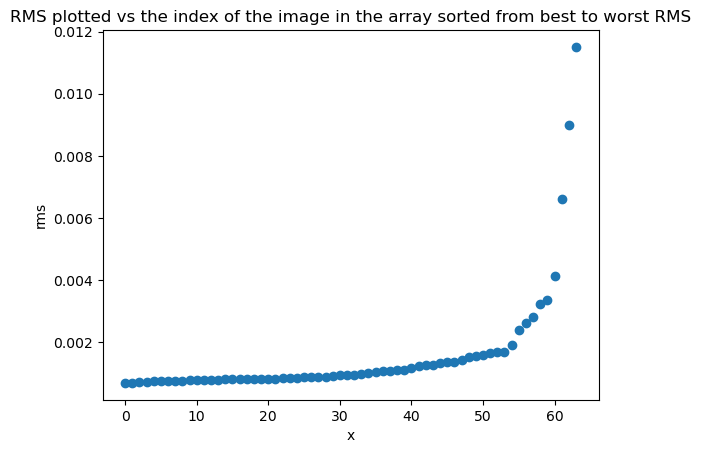

In [37]:
rms = np.nanstd(sin_aper, axis = (1, 2)) #gives an array with rms's for every aperture of every image
rms_idx = np.argsort(rms) #makes an array with the best index first and the worst index last
rms_sort = rms[rms_idx] #sorts the rms array from best to worst

plt.figure()
plt.title('RMS plotted vs the index of the image in the array sorted from best to worst RMS')
plt.scatter(np.arange(0, len(rms_sort)), rms_sort)
plt.xlabel('x')
plt.ylabel('rms')
plt.show()

In [35]:
sin_aper_data_sort = sin_clb[rms_idx] #sorts the single star array from best rms to worst rms
sin_names_sort = sin_names[rms_idx] #if we ever need to know which star is which

In [36]:
#Make an array in which every ith entry is a median of the images from 0 to i in the array sorted from best to
#worst rms
rms_med_im = np.empty(len(sin_aper_data_sort))
for i in range(len(sin_aper_data_sort)):
    idx_arr = rms_idx[0:i+1]
    med = np.median(sin_aper_data_sort[idx_arr], axis = 0)
    med_aper = mask_aperture(med)
    rms_med_im[i] = np.nanstd(med_aper)

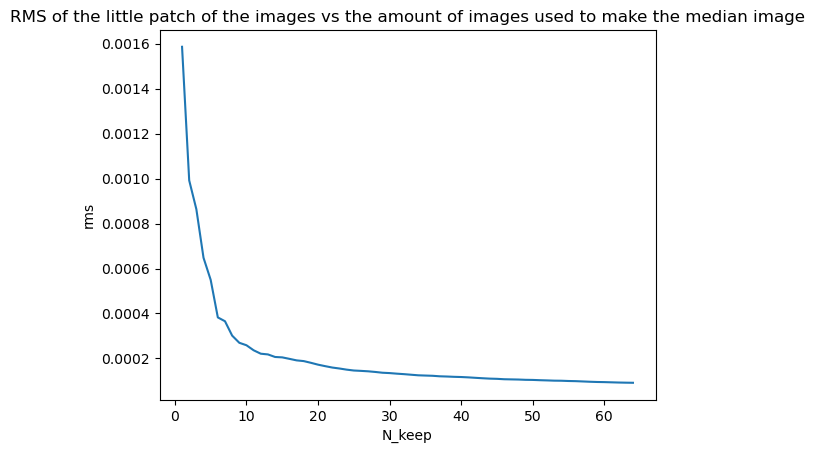

In [20]:
N_keep = np.arange(1, len(rms_med_im)+1)
plt.figure()
plt.title('RMS of the little patch of the images vs the amount of images used to make the median image')
plt.plot(N_keep, rms_med_im/np.sqrt(N_keep))
#plt.plot(N_keep, 1/np.sqrt(N_keep))
plt.ylabel('rms')
plt.xlabel('N_keep')
plt.show()

In [ ]:
plt.imshow(sin_data_sort[4])

In [ ]:
#Make an array in which every ith entry is the rms image of the images 0 to i sorted from worst to best rms 
#in the aperture
rms_images = np.empty(len(sin_data_sort))
for i in range(len(sin_data_sort)):
    idx_arr = rms_idx[0:i+1]
    
    rms_med_im[i] = np.nanstd(med_aper)

# 5. Subtract median star from test stars

In [ ]:
def subtract_star(im, med_st):
    ''' Subtract the median star from the image and images the results'''
    im = calibration(im, 100)
    dx = im - med_st
    return dx

In [ ]:
rest = subtract_star(star_data(0, single_stars), med_arr)
name, date = star_info(0, single_stars)
plt.title(f'{name}, {date}')
plt.imshow(rest)
plt.colorbar()
plt.xlim(400, 624)
plt.ylim(400, 624)
plt.show()

In [ ]:
for i in range(len(single_stars)):
    rest = subtract_star(star_data(i, single_stars), med_arr)
    name, date = star_info(i, single_stars)
#     plt.title(f'{name}, {date}')
#     plt.imshow(rest)
#     plt.colorbar()
#     plt.xlim(500, 524)
#     plt.ylim(500, 524)
#     plt.show()
    
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(rest)
    plt.xlim(400, 624)
    plt.ylim(400, 624)

    plt.subplot(1,2,2)
    plt.imshow(rest)
    plt.colorbar()
    plt.xlim(500, 524)
    plt.ylim(500, 524)

    plt.suptitle(f'{name}, {date}')
    plt.show()

In [ ]:
subtract_star(star_data(path_sin, 1), med_arr)
name, date = star_info(path_sin, 1)
plt.title(f'{name}, {date}')
plt.imshow(rest)
plt.colorbar()
plt.xlim(500, 524)
plt.ylim(500, 524)
plt.show()

# .reg files
1. Want to open them
2. Want to be able to read them
3. Search for key word circle
4. Save x and y coordinate
    - Are all coordinates equally long? --> if not begin next at ,
    - Do not save radius too

In [ ]:
def find_x_y_reg(file, loc_circle, sep):
    ''' Opens the .reg file and returns the x and y coordinate in the file. loc_circle is the number of the line
    where the information on the circle is stored and sep is the thing used for seperating the x and y coord. '''
    with open(file, 'rt') as reg:
        data_reg = reg.readlines()
        data_reg = data_reg[loc_circle]
    
    first, second = data_reg.find(sep), data_reg.rfind(sep)
    return float(data_reg[7:first]), float(data_reg[(first+1):second])

In [ ]:
x, y = find_x_y_reg(f'data/{star}/{date}/{star}_{date}.reg', 3, ',')

In [ ]:
x